In [37]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import shap
import matplotlib.pyplot as plt

In [38]:
model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 10)  # Eurosat has 10 classes
model.load_state_dict(torch.load(r"C:\Users\Ekaansh\OneDrive\Desktop\AB\vs code\JS\projects\satelite\test 2\eurosat_resnet18.pth"))
model.eval()


C:\Users\Ekaansh\AppData\Local\Temp\ipykernel_6000\1667282932.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\Ekaansh\OneDriv

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [43]:
def replace_relu(module):
    for name, child in module.named_children():
        if isinstance(child, nn.ReLU) and child.inplace:
            setattr(module, name, nn.ReLU(inplace=False))
        else:
            replace_relu(child)

replace_relu(model)

In [44]:
for module in model.modules():
    if hasattr(module, 'inplace') and module.inplace:
        module.inplace = False

# ===== 2. Transforms =====
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [45]:
img_path = r"C:\Users\Ekaansh\Downloads\title.jpg"
image = Image.open(img_path).convert('RGB')
input_tensor = transform(image).unsqueeze(0)

In [47]:
# Patch ResNet blocks to avoid inplace addition
from torchvision.models.resnet import BasicBlock, Bottleneck

def patched_basicblock_forward(self, x):
    identity = x
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)

    if self.downsample is not None:
        identity = self.downsample(x)

    out = out + identity  # No inplace
    out = self.relu(out)

    return out

def patched_bottleneck_forward(self, x):
    identity = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)
    out = self.relu(out)

    out = self.conv3(out)
    out = self.bn3(out)

    if self.downsample is not None:
        identity = self.downsample(x)

    out = out + identity  # No inplace
    out = self.relu(out)

    return out

BasicBlock.forward = patched_basicblock_forward
Bottleneck.forward = patched_bottleneck_forward

In [51]:
background = torch.randn((5, 3, 224, 224))  # 5 random samples as background

# ===== 5. SHAP DeepExplainer =====
explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(input_tensor, check_additivity=False)

TypeError: Invalid shape (3, 224, 224) for image data

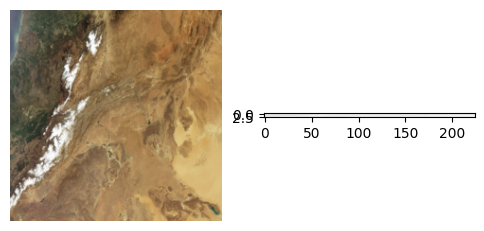

In [54]:
# Prepare image for shap.image_plot (shape: [batch, height, width, channels])
img_np = input_tensor.squeeze(0).permute(1, 2, 0).numpy()
img_np = img_np[np.newaxis, ...]  # Add batch dimension
shap.image_plot(shap_values, img_np)